## 导入工具包

In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import random
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from time import time
from PIL import Image
from sklearn import cluster
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

## 数据预处理

得到paths

In [2]:
paths = []
file_names = os.listdir('faces_4/')
#分类类别
direction,name,wear_sunglasses,expression=[],[],[],[]
for file in file_names:
    images = os.listdir('faces_4/' + file + '/' )
    for image in images:
        #通过文件名中的_区分人名、方向、表情、有没有戴sunglasses
        str_list = image.split('_')
        if str_list[0] not in name:
            name.append(str_list[0])
        if str_list[1] not in direction:
            direction.append(str_list[1])
        if str_list[2] not in expression:
            expression.append(str_list[2])
        if str_list[3] not in wear_sunglasses:
            wear_sunglasses.append(str_list[3])
        paths.append('faces_4/' + file + '/'  + image)

In [3]:
print(name)
print(direction)
print(expression)
print(wear_sunglasses)

['an2i', 'at33', 'boland', 'bpm', 'ch4f', 'cheyer', 'choon', 'danieln', 'glickman', 'karyadi', 'kawamura', 'kk49', 'megak', 'mitchell', 'night', 'phoebe', 'saavik', 'steffi', 'sz24', 'tammo']
['left', 'right', 'straight', 'up']
['angry', 'happy', 'neutral', 'sad']
['open', 'sunglasses']


In [4]:
def construct_data(path): 
    im,names,directions,expressions,sunglasses = [],[],[],[],[]
    for file in path:
        #构造data
        image = Image.open(file).convert("L")
        #如果图像的模式是“1”，“L”，“P”等模式，因为这些模式是8bit表示一个像素，
        #所以这些模式的颜色值的范围是在0~255，所以getdata（）的返回值的元素就不是上述的（R,G,B）的形式了，而是0~255中的任意一个数
        im.append(np.array(list(image.getdata())))
        #im.getdata()函数的返回值是一个sequence对象，sequence对象的每一个元素对应一个像素点R、G、B值
        #可以用list（）将sequence对象转为普通的sequence对象
        str1 = file.split('_')
        #因为这里包括了faces_4/，所以要把"/"分割开
        str2=str1[1].split('/')
#         print(str2)
        a=0
        for i in range(len(name)):
            if name[i]==str2[2]:
                a=i      
        b=0
        for i in range(len(direction)):
            if direction[i]==str1[2]:
                b=i
        c=0
        for i in range(len(expression)):
            if expression[i]==str1[3]:
                c=i
        d=0
        for i in range(len(wear_sunglasses)):
            if wear_sunglasses[i]==str1[4]:
                d=i

        names.append(a)
        directions.append(b)
        expressions.append(c)
        sunglasses.append(d)

    return {'data': np.array(im), 'name': np.array(names), 'direction': np.array(directions), 'expression': np.array(expressions),'wear_sunglasses': np.array(sunglasses)}

In [5]:
random.shuffle(paths)#原来的paths是按照顺序的，先要打乱顺序，然后选择前305个为训练集，剩下的图片为测试集
train = construct_data(paths[:305])
test = construct_data(paths[305:])

In [6]:
train

{'data': array([[46, 45, 43, ...,  0,  0,  0],
        [41, 39, 37, ..., 20, 45, 45],
        [34, 33, 31, ..., 50, 49, 49],
        ...,
        [38, 35, 33, ...,  3, 12,  0],
        [37, 38, 40, ..., 22,  3,  0],
        [ 6,  0, 28, ..., 19, 19, 17]]),
 'name': array([10,  6,  2,  9,  4,  4,  1,  0,  4, 18,  0,  0, 14,  4,  4,  7,  1,
         2,  6, 16, 11, 12,  1, 16,  1,  9,  7, 10,  3, 13,  5, 11,  6, 14,
         1, 18, 14,  3,  2,  1, 14, 14, 19,  6,  3,  8,  8,  0,  2,  6, 13,
         8, 15, 16, 19,  4, 18,  1, 19, 11, 16,  2,  1,  9,  3, 13, 17, 15,
         5,  3, 16, 16,  3,  7,  7,  2,  6,  6, 17, 10,  1, 17, 15,  2, 11,
         1,  6,  8,  9, 16, 15,  2, 19,  7, 11, 19, 17,  9, 13, 18, 12, 13,
         8, 17, 15, 14, 11, 19, 10, 16, 10,  0, 18,  5,  3,  0,  4,  8,  5,
        15, 18,  6, 10,  2, 12, 11, 13,  6,  1, 15,  1,  3, 13, 15,  7,  5,
        13,  3, 15,  3, 16, 10, 12,  6,  7, 16,  3,  2, 18,  2,  6,  9,  1,
        18, 16, 19, 13,  8,  0,  9,  7,  7, 17,  3,

In [7]:
test['data'].shape

(319, 960)

In [8]:
train['data'].shape

(305, 960)

## 任务一：人脸识别（区分人脸名称）

### 法一：SVM

In [9]:
param_grid = {'C': [0.1,1,10,1e2]}
svm = GridSearchCV(
    SVC(kernel='rbf'), param_grid
)
svm = svm.fit(train['data'],train['name'])
svm.best_estimator_

SVC(C=1)

In [10]:
y_pred_svm = svm.predict(test['data'])
print(classification_report(test['name'], y_pred_svm, target_names=name))

              precision    recall  f1-score   support

        an2i       1.00      1.00      1.00        17
        at33       1.00      0.88      0.94        17
      boland       0.94      1.00      0.97        15
         bpm       0.88      1.00      0.94        15
        ch4f       1.00      1.00      1.00        16
      cheyer       1.00      1.00      1.00        20
       choon       1.00      1.00      1.00        14
     danieln       1.00      1.00      1.00        14
    glickman       1.00      1.00      1.00        16
     karyadi       1.00      1.00      1.00        16
    kawamura       1.00      1.00      1.00        19
        kk49       1.00      0.95      0.97        19
       megak       1.00      1.00      1.00        16
    mitchell       1.00      1.00      1.00        13
       night       1.00      1.00      1.00        18
      phoebe       1.00      1.00      1.00        14
      saavik       1.00      1.00      1.00        12
      steffi       1.00    

最终准确率达到0.99，效果不错

### 法二：神经网络

In [11]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(20, activation = "softmax", kernel_regularizer = tf.keras.regularizers.l2()) ])
model.compile(  
    optimizer = tf.keras.optimizers.SGD(lr = 0.009), 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics = ['accuracy'] 
)
history=model.fit( 
    train['data'], train['name'], 
    batch_size = 64, 
    epochs = 200, 
    validation_split = 0.2
)
model.summary() 

Epoch 1/200
4/4 [==============================] - 0s 53ms/step - loss: 1717.3986 - accuracy: 0.0984 - val_loss: 3965.0913 - val_accuracy: 0.0656
Epoch 2/200
4/4 [==============================] - 0s 10ms/step - loss: 4845.0298 - accuracy: 0.1311 - val_loss: 3377.0330 - val_accuracy: 0.2295
Epoch 3/200
4/4 [==============================] - 0s 9ms/step - loss: 4696.6606 - accuracy: 0.2008 - val_loss: 3863.6926 - val_accuracy: 0.3443
Epoch 4/200
4/4 [==============================] - 0s 7ms/step - loss: 3851.8452 - accuracy: 0.2254 - val_loss: 2917.7673 - val_accuracy: 0.3443
Epoch 5/200
4/4 [==============================] - 0s 7ms/step - loss: 2724.8682 - accuracy: 0.3361 - val_loss: 1269.5687 - val_accuracy: 0.4262
Epoch 6/200
4/4 [==============================] - 0s 7ms/step - loss: 683.9223 - accuracy: 0.5615 - val_loss: 218.7901 - val_accuracy: 0.6557
Epoch 7/200
4/4 [==============================] - 0s 8ms/step - loss: 98.5399 - accuracy: 0.8238 - val_loss: 122.6422 - val_accur

In [12]:
y_pred=model.predict(test['data'])

In [13]:
np.argmax(y_pred[1])

5

In [14]:
y_pred[1]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

由于人名有20类，最后网络输出的是独热向量编码，需要将它转变成对应的第几类

In [15]:
y_pred_keras=[]
for x in y_pred:
    y_pred_keras.append(np.argmax(x))
    

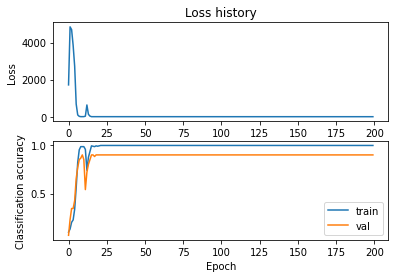

In [16]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.title('Loss history')
# plt.xlabel('epoch')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
# plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

In [17]:
print(classification_report(test['name'], y_pred_keras, target_names=name))

              precision    recall  f1-score   support

        an2i       1.00      1.00      1.00        17
        at33       0.94      1.00      0.97        17
      boland       0.79      1.00      0.88        15
         bpm       1.00      1.00      1.00        15
        ch4f       1.00      1.00      1.00        16
      cheyer       1.00      0.95      0.97        20
       choon       0.93      1.00      0.97        14
     danieln       0.93      1.00      0.97        14
    glickman       1.00      1.00      1.00        16
     karyadi       1.00      1.00      1.00        16
    kawamura       1.00      1.00      1.00        19
        kk49       1.00      0.84      0.91        19
       megak       1.00      1.00      1.00        16
    mitchell       0.93      1.00      0.96        13
       night       1.00      1.00      1.00        18
      phoebe       1.00      0.86      0.92        14
      saavik       1.00      1.00      1.00        12
      steffi       1.00    

最后达到97%的准确率，效果不错

### 区分人脸朝向

In [20]:
param_grid = {'C': [0.1,0.5,1,10,20,50,1e2]}
svm_1 = GridSearchCV(
    SVC(kernel='rbf'), param_grid
)
svm_1 = svm_1.fit(train['data'],train['direction'])
svm_1.best_estimator_

SVC(C=10)

In [21]:
y_pred_svm_1 = svm_1.predict(test['data'])
print(classification_report(test['direction'], y_pred_svm_1, target_names=direction))

              precision    recall  f1-score   support

        left       0.99      0.95      0.97        84
       right       1.00      1.00      1.00        87
    straight       0.93      0.97      0.95        71
          up       0.96      0.96      0.96        77

    accuracy                           0.97       319
   macro avg       0.97      0.97      0.97       319
weighted avg       0.97      0.97      0.97       319



最后准确率达到97%，效果不错

In [45]:
left = []
right=[]
straight=[]
up=[]
for i in range(0,319):
    if y_pred_svm_1[i]==0:
        left.append(i)
    elif y_pred_svm_1[i]==1:
        right.append(i)
    elif y_pred_svm_1[i]==2:
        straight.append(i)
    else:
        up.append(i)

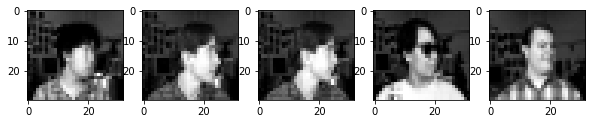

In [46]:
plt.figure(figsize=(10,10))
cnt = 0
for j in left:
    plt.subplot(5,5,cnt+1)
    plt.imshow(test['data'][j].reshape(30,32),cmap = 'gray')
    cnt+=1
    if cnt == 5:
        break

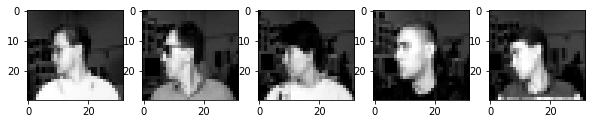

In [47]:
plt.figure(figsize=(10,10))
cnt = 0
for j in right:
    plt.subplot(5,5,cnt+1)
    plt.imshow(test['data'][j].reshape(30,32),cmap = 'gray')
    cnt+=1
    if cnt == 5:
        break

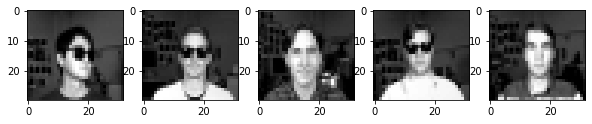

In [48]:
plt.figure(figsize=(10,10))
cnt = 0
for j in straight:
    plt.subplot(5,5,cnt+1)
    plt.imshow(test['data'][j].reshape(30,32),cmap = 'gray')
    cnt+=1
    if cnt == 5:
        break

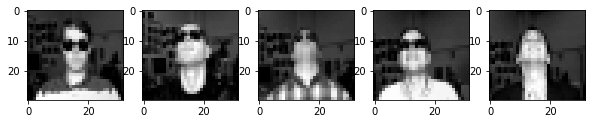

In [43]:
plt.figure(figsize=(10,10))
cnt = 0
for j in up:
    plt.subplot(5,5,cnt+1)
    plt.imshow(test['data'][j].reshape(30,32),cmap = 'gray')
    cnt+=1
    if cnt == 5:
        break

### 区分人脸是否戴sunglasses

In [22]:
param_grid = {'C': [0.1,0.5,1,10,20,50,1e2]}
svm_2 = GridSearchCV(
    SVC(kernel='rbf'), param_grid
)
svm_2.fit(train['data'],train['wear_sunglasses'])
y_pred_svm_2 = svm_2.predict(test['data'])
print(classification_report(test['wear_sunglasses'], y_pred_svm_2, target_names=wear_sunglasses))

              precision    recall  f1-score   support

        open       0.90      0.92      0.91       162
  sunglasses       0.92      0.89      0.90       157

    accuracy                           0.91       319
   macro avg       0.91      0.91      0.91       319
weighted avg       0.91      0.91      0.91       319



准确率达到91%，效果不错

In [35]:
wearing_sunglasses = []
not_wearing_sunglasses=[]
for i in range(0,319):
    if y_pred_svm_2[i]==1:
        wearing_sunglasses.append(i)
    else:
        not_wearing_sunglasses.append(i)

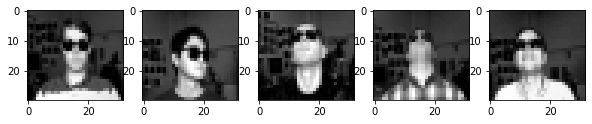

In [36]:
plt.figure(figsize=(10,10))
cnt = 0
for j in wearing_sunglasses:
    plt.subplot(5,5,cnt+1)
    plt.imshow(test['data'][j].reshape(30,32),cmap = 'gray')
    cnt+=1
    if cnt == 5:
        break

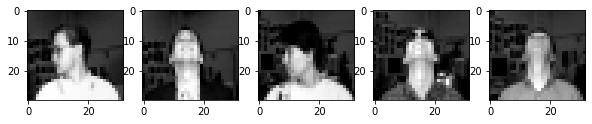

In [37]:
plt.figure(figsize=(10,10))
cnt = 0
for j in not_wearing_sunglasses:
    plt.subplot(5,5,cnt+1)
    plt.imshow(test['data'][j].reshape(30,32),cmap = 'gray')
    cnt+=1
    if cnt == 5:
        break

可视化查看前5个样本后的效果也不错

## 任务二：发现表情相似的图(区分表情)

### 法一：SVM

In [25]:
param_grid = {'C': [0.1,0.5,1,10,1e2]}
svm_3 = GridSearchCV(
    SVC(kernel='rbf'), param_grid
)
svm_3 = svm_3.fit(train['data'],train['expression'])
svm_3.best_estimator_

SVC(C=0.1)

In [26]:
y_pred_svm_3 = svm_3.predict(test['data'])
print(classification_report(test['expression'], y_pred_svm_3, target_names=expression))

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        83
       happy       0.23      1.00      0.37        73
     neutral       0.00      0.00      0.00        87
         sad       0.00      0.00      0.00        76

    accuracy                           0.23       319
   macro avg       0.06      0.25      0.09       319
weighted avg       0.05      0.23      0.09       319



最后准确率才23%,效果不佳，基本上就等于盲猜了

### 使用神经网络发现表情相似的图

In [27]:
model = tf.keras.models.Sequential([ tf.keras.layers.Dense(4, activation = "softmax", kernel_regularizer = tf.keras.regularizers.l2()) #全连接层，三个神经元，激活函数为softmax,使用l2正则化])
model.compile( 
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics = ['accuracy']
)
history=model.fit( 
    train['data'], train['expression'],
    batch_size = 64,
    epochs = 300, 
    validation_split = 0.2,
)
model.summary() 

Epoch 1/300
4/4 [==============================] - 1s 81ms/step - loss: 6557.1299 - accuracy: 0.2787 - val_loss: 793.6417 - val_accuracy: 0.2459
Epoch 2/300
4/4 [==============================] - 0s 8ms/step - loss: 4142.5859 - accuracy: 0.2746 - val_loss: 7613.0078 - val_accuracy: 0.3115
Epoch 3/300
4/4 [==============================] - 0s 8ms/step - loss: 7457.6401 - accuracy: 0.2418 - val_loss: 8011.5161 - val_accuracy: 0.3115
Epoch 4/300
4/4 [==============================] - 0s 7ms/step - loss: 7329.0635 - accuracy: 0.2582 - val_loss: 8152.4526 - val_accuracy: 0.3115
Epoch 5/300
4/4 [==============================] - 0s 8ms/step - loss: 7359.2407 - accuracy: 0.2418 - val_loss: 8654.7012 - val_accuracy: 0.3115
Epoch 6/300
4/4 [==============================] - 0s 8ms/step - loss: 7157.1260 - accuracy: 0.2705 - val_loss: 7775.9404 - val_accuracy: 0.3115
Epoch 7/300
4/4 [==============================] - 0s 8ms/step - loss: 7965.5073 - accuracy: 0.2336 - val_loss: 8150.3154 - val_ac

In [28]:
y_pred=model.predict(test['data'])

In [29]:
y_pred.shape

(319, 4)

In [30]:
y_pred_expre=[]
for x in y_pred:
    y_pred_expre.append(np.argmax(x))

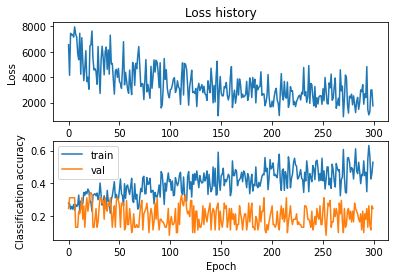

In [31]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.title('Loss history')
# plt.xlabel('epoch')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
# plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

In [32]:
print(classification_report(test['expression'], y_pred_expre, target_names=expression))

              precision    recall  f1-score   support

       angry       0.26      0.18      0.21        83
       happy       0.16      0.37      0.22        73
     neutral       0.18      0.18      0.18        87
         sad       0.00      0.00      0.00        76

    accuracy                           0.18       319
   macro avg       0.15      0.18      0.15       319
weighted avg       0.15      0.18      0.16       319



最后效果很差，才0.18

### 法三：kmeas聚类算法

In [33]:
kmeans = cluster.KMeans(init='k-means++', n_clusters=4, random_state=1,max_iter = 1000)#有四类表情，所以n_clusters=4
kmeans.fit(train['data'])
y_pred_kmeans = kmeans.predict(test['data'])
print(classification_report(test['expression'], y_pred_kmeans, target_names=expression))

              precision    recall  f1-score   support

       angry       0.26      0.17      0.21        83
       happy       0.21      0.42      0.28        73
     neutral       0.24      0.15      0.18        87
         sad       0.26      0.22      0.24        76

    accuracy                           0.24       319
   macro avg       0.24      0.24      0.23       319
weighted avg       0.24      0.24      0.23       319



效果很差，24%，和盲猜差不多